In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tflite_support import metadata as _metadata

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Prepare training and validation datasets

In [2]:
batch_size = 32
img_height = 180
img_width = 180

directory = "/home/atti/Documents/PV162_CV/IMAGES/Coins/CZK"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

Found 369 files belonging to 6 classes.
Using 296 files for training.
Found 369 files belonging to 6 classes.
Using 73 files for validation.


In [3]:
#class_names = train_ds.class_names
class_names = ['1', '10', '2', '20', '5', '50']
print("Class names: " + str(class_names))
with open("labelmap.txt", "w") as f:
    for c in class_names:
        f.write(c)
        f.write('\n')

Class names: ['1', '10', '2', '20', '5', '50']


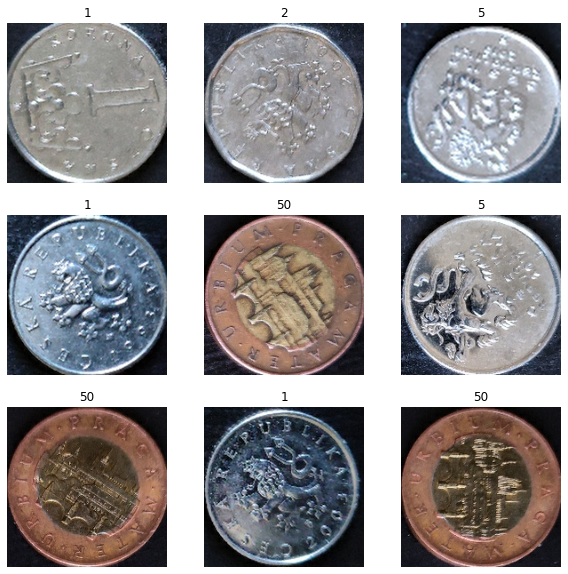

In [4]:
images, labels = next(iter(train_ds.skip(3).take(1)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Optimize for performance

`Dataset.cache()` - to keep the images in memory after they're loaded off disk during the first epoch

`Dataset.prefetch()` - overlaps data preprocessing and model execution while training

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize the dataset

`[0, 255] -> [0, 1]`

In [6]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

## Data augmentation

 - randomly rotate by 180 degrees
 - randomly flip horizontally

In [7]:
data_augmentation_layer = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        # TODO vertial flip
        layers.experimental.preprocessing.RandomRotation(0.5),
    ]
)

## Create the model

In [8]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes),
])

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

## Train the model

In [9]:
epochs=50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
10/10 [==============================] - 3s 328ms/step - loss: 1.7821 - accuracy: 0.1926 - val_loss: 46.2368 - val_accuracy: 0.4110
Epoch 2/50
10/10 [==============================] - 3s 297ms/step - loss: 1.3879 - accuracy: 0.5000 - val_loss: 120.7406 - val_accuracy: 0.5753
Epoch 3/50
10/10 [==============================] - 4s 353ms/step - loss: 1.0831 - accuracy: 0.5372 - val_loss: 81.8732 - val_accuracy: 0.5616
Epoch 4/50
10/10 [==============================] - 3s 331ms/step - loss: 0.9278 - accuracy: 0.5507 - val_loss: 63.3645 - val_accuracy: 0.5616
Epoch 5/50
10/10 [==============================] - 3s 318ms/step - loss: 0.8485 - accuracy: 0.5946 - val_loss: 31.5460 - val_accuracy: 0.6986
Epoch 6/50
10/10 [==============================] - 3s 331ms/step - loss: 0.8000 - accuracy: 0.6182 - val_loss: 39.3734 - val_accuracy: 0.6712
Epoch 7/50
10/10 [==============================] - 3s 280ms/step - loss: 0.7386 - accuracy: 0.6993 - val_loss: 47.3814 - val_accuracy: 0.684

## Visualize training results

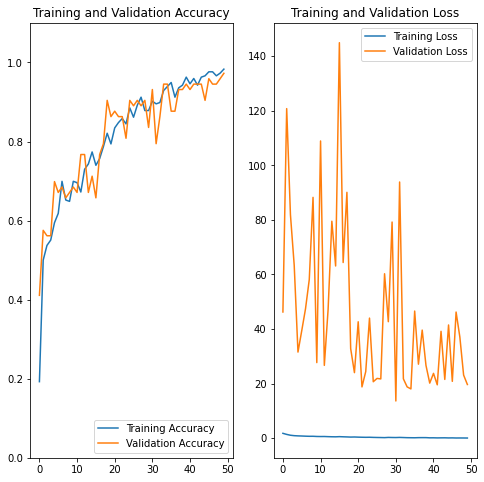

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0,1.1])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Predicted: 2 with a 89.85% confidence.
Correct: 2


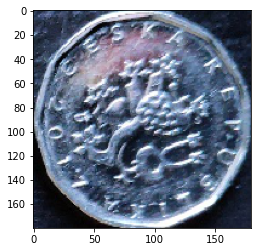

In [11]:
import random

class_num = 2

# get image path
img_dir_path = directory + "/" + str(class_names[class_num])
img_dir = os.listdir(img_dir_path)
img_name = img_dir[random.randint(0, len(img_dir)-1)]
img_path = img_dir_path + "/" + img_name

# load image
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)/255.
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

# predict
predictions = model.predict(img_array_batch)
score = tf.nn.softmax(predictions[0])

# show results
plt.imshow(img_array)

print(
    "Predicted: {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print("Correct: " + str(class_names[class_num]))

## Export to .tflite

In [12]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpuolzo3hq/assets


In [13]:
print(tf.__version__)

2.3.0
